In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import random

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import random

# Inference model: A simple CNN to classify MNIST images
class InferenceModel(nn.Module):
    def __init__(self):
        super(InferenceModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)  # Updated to match the flattened size
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(torch.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)  # Flatten, keeping batch dimension
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class CriticModel(nn.Module):
    def __init__(self):
        super(CriticModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)  # Updated to match the flattened size
        self.fc2 = nn.Linear(128, 1)  # Output predicted future reward

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(torch.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Actor: Chooses whether to learn from the image based on the Critic's prediction
class Actor:
    def __init__(self, epsilon):
        self.epsilon = epsilon  # Exploration vs exploitation

    def choose_action(self, expected_reward):
        # Epsilon-greedy decision: Explore or exploit based on the critic's prediction
        if random.uniform(0, 1) < self.epsilon:
            return random.choice([0, 1])  # Random action (0: skip, 1: learn)
        else:
            return 1 if expected_reward > 0 else 0  # Exploit (1: learn, 0: skip)

# Main RL process: Actor-Critic training loop
def train_actor_critic(num_epochs=5):
    # Load MNIST dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)

    # Initialize models
    inference_model = InferenceModel()
    critic_model = CriticModel()
    actor = Actor(epsilon=0.1)

    # Optimizers
    inference_optimizer = optim.Adam(inference_model.parameters(), lr=0.001)
    critic_optimizer = optim.Adam(critic_model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    total_reward = 0
    num_learned = 0

    for epoch in range(num_epochs):
        epoch_reward = 0
        epoch_learned = 0

        for i, (data, target) in enumerate(train_loader):
            if i > 625:
                break
            data, target = data.float(), target.long()

            # Step 1: Critic predicts future reward for the image
            expected_reward = critic_model(data)

            # Step 2: Actor decides whether to learn from this image
            action = actor.choose_action(expected_reward.item())

            if action == 1:  # Actor decides to learn from the data point
                # Step 3: Inference model processes the data and computes the loss
                inference_optimizer.zero_grad()
                prediction = inference_model(data)

                loss = loss_fn(prediction, target)
                loss.backward()
                inference_optimizer.step()

                # Step 4: The loss is used as a negative reward (lower loss = higher reward)
                reward = -loss.item()

                # Step 5: Update the Critic using the loss (reward)
                critic_optimizer.zero_grad()
                target_value = torch.tensor([[reward]], dtype=torch.float32)
                critic_loss = nn.MSELoss()(expected_reward, target_value)
                critic_loss.backward()
                critic_optimizer.step()

                epoch_reward += reward
                epoch_learned += 1

            if (i + 1) % 1000 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                      f"Learned: {epoch_learned}, Avg Reward: {epoch_reward/max(1, epoch_learned):.4f}")

        total_reward += epoch_reward
        num_learned += epoch_learned
        print(f"Epoch [{epoch+1}/{num_epochs}] Summary - "
              f"Learned: {epoch_learned}/{len(train_loader)}, "
              f"Avg Reward: {epoch_reward/max(1, epoch_learned):.4f}")

    print(f"Training Complete. Total Learned: {num_learned}/{len(train_loader)*num_epochs}, "
          f"Overall Avg Reward: {total_reward/max(1, num_learned):.4f}")

    return inference_model, critic_model

# Train the model
trained_inference_model, trained_critic_model = train_actor_critic(num_epochs=1)

Epoch [1/1] Summary - Learned: 37/60000, Avg Reward: -2.3746
Training Complete. Total Learned: 37/60000, Overall Avg Reward: -2.3746


In [43]:
data_loader = load_mnist_test_data()

In [49]:
for i, (data, target) in enumerate(data_loader):
    data, target = data.float(), target.long()

    # Step 1: Critic predicts future reward for the image
    expected_reward = trained_critic_model(data)

    print(f"Image {target}, Expected Reward: {expected_reward.item()}")

    if i == 100:
        break

Image tensor([7]), Expected Reward: -2.6256139278411865
Image tensor([2]), Expected Reward: -2.491209030151367
Image tensor([1]), Expected Reward: -2.4989025592803955
Image tensor([0]), Expected Reward: -2.701280117034912
Image tensor([4]), Expected Reward: -2.560748338699341
Image tensor([1]), Expected Reward: -2.5468525886535645
Image tensor([4]), Expected Reward: -2.738516092300415
Image tensor([9]), Expected Reward: -2.515186071395874
Image tensor([5]), Expected Reward: -2.521876096725464
Image tensor([9]), Expected Reward: -2.6867361068725586
Image tensor([0]), Expected Reward: -2.739483118057251
Image tensor([6]), Expected Reward: -2.734898805618286
Image tensor([9]), Expected Reward: -2.6807053089141846
Image tensor([0]), Expected Reward: -2.645320177078247
Image tensor([1]), Expected Reward: -2.724080801010132
Image tensor([5]), Expected Reward: -2.5755856037139893
Image tensor([9]), Expected Reward: -2.7072575092315674
Image tensor([7]), Expected Reward: -2.5939390659332275
Im

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Load the test dataset
def load_mnist_test_data():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    return torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# Evaluate the model
def evaluate_model(model, data_loader):
    model.eval()
    class_correct = np.zeros(10)
    class_total = np.zeros(10)
    
    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            label = target.item()
            
            class_total[label] += 1
            if predicted.item() == label:
                class_correct[label] += 1

    class_accuracy = class_correct / class_total
    return class_accuracy

# Plot the results
def plot_classification_performance(class_accuracy):
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), class_accuracy, color='skyblue')
    plt.xlabel('Digit Class')
    plt.ylabel('Accuracy')
    plt.title('Classification Performance of Each Digit')
    plt.xticks(range(10), [str(i) for i in range(10)])
    plt.ylim(0, 1)
    plt.show()


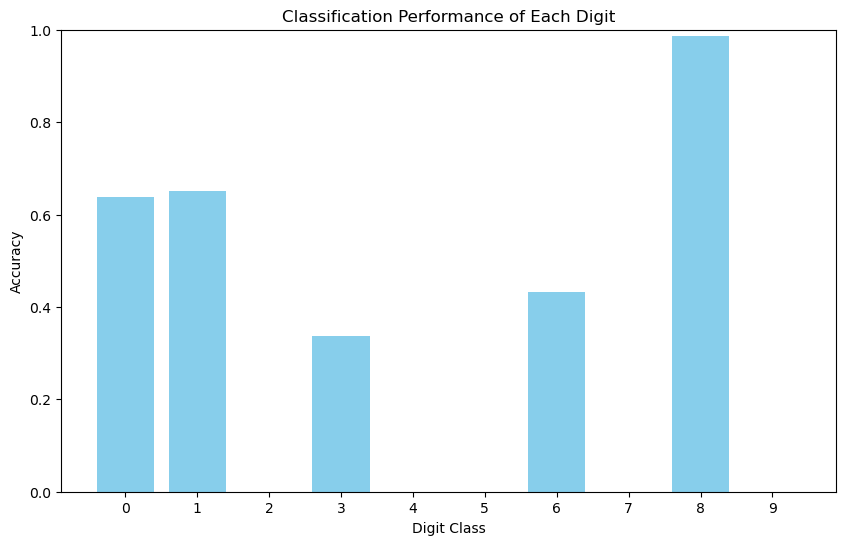

In [31]:
#  625 (625 * 6% = 37.5) images are used for training
# Load the test data
test_loader = load_mnist_test_data()

# Evaluate the model
class_accuracy = evaluate_model(trained_inference_model, test_loader)

# Plot the classification performance
plot_classification_performance(class_accuracy)

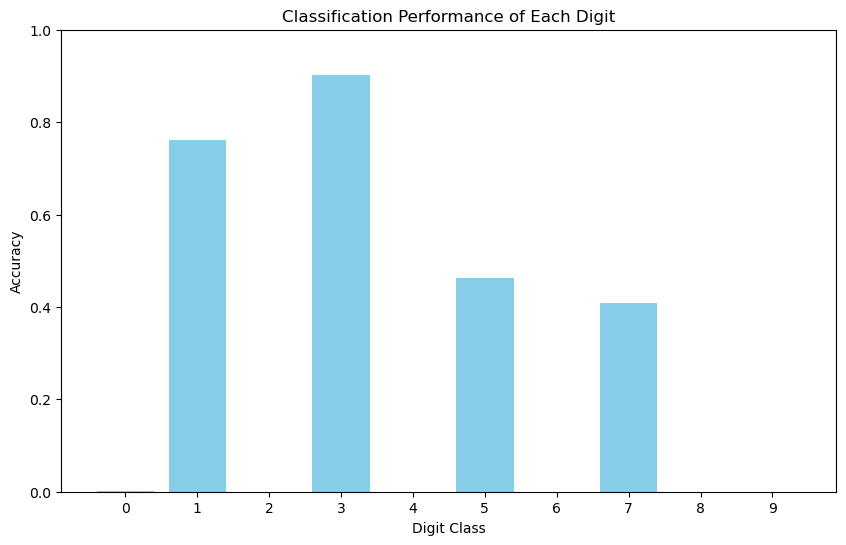

In [29]:
# 1250 (1250 * 6% = 75) images are used for training
# Load the test data
test_loader = load_mnist_test_data()

# Evaluate the model
class_accuracy = evaluate_model(trained_inference_model, test_loader)

# Plot the classification performance
plot_classification_performance(class_accuracy)

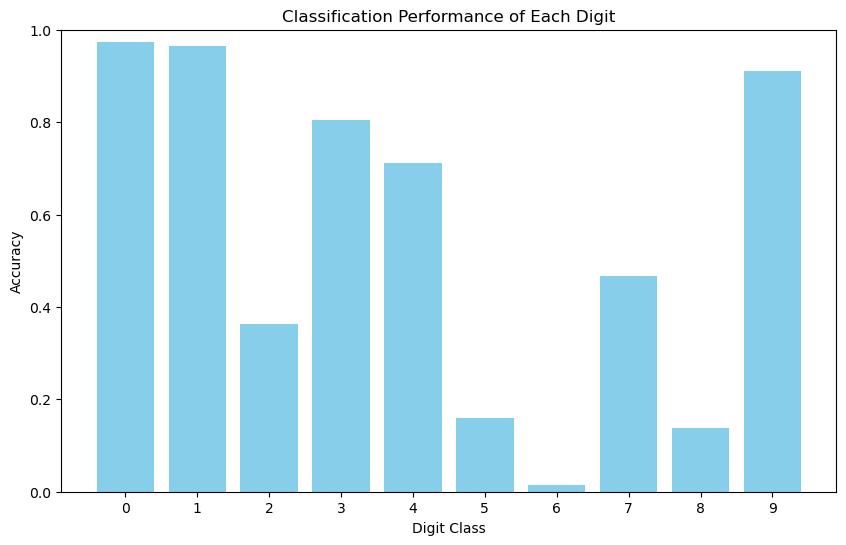

In [27]:
# 2500 (2500 * 6% = 150) images are used for training
# Load the test data
test_loader = load_mnist_test_data()

# Evaluate the model
class_accuracy = evaluate_model(trained_inference_model, test_loader)

# Plot the classification performance
plot_classification_performance(class_accuracy)

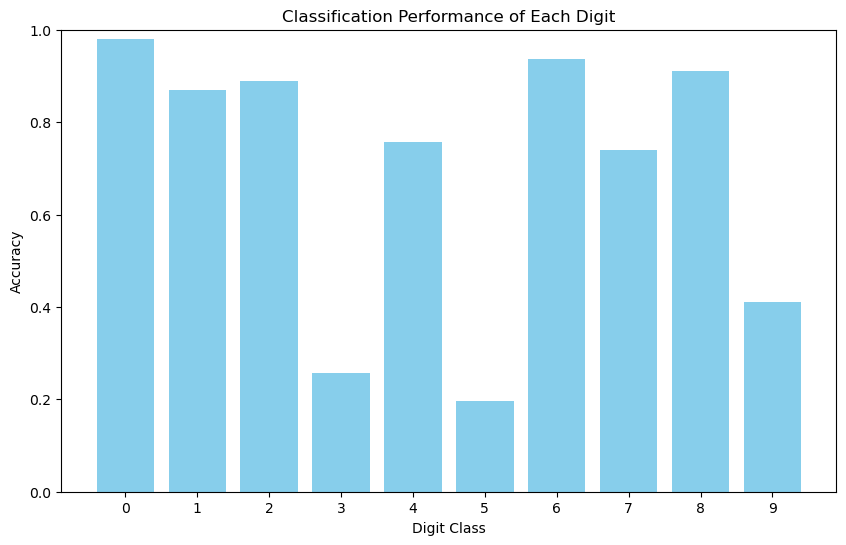

In [25]:
# 5000 (5000 * 6% = 300) images are used for training
# Load the test data
test_loader = load_mnist_test_data()

# Evaluate the model
class_accuracy = evaluate_model(trained_inference_model, test_loader)

# Plot the classification performance
plot_classification_performance(class_accuracy)

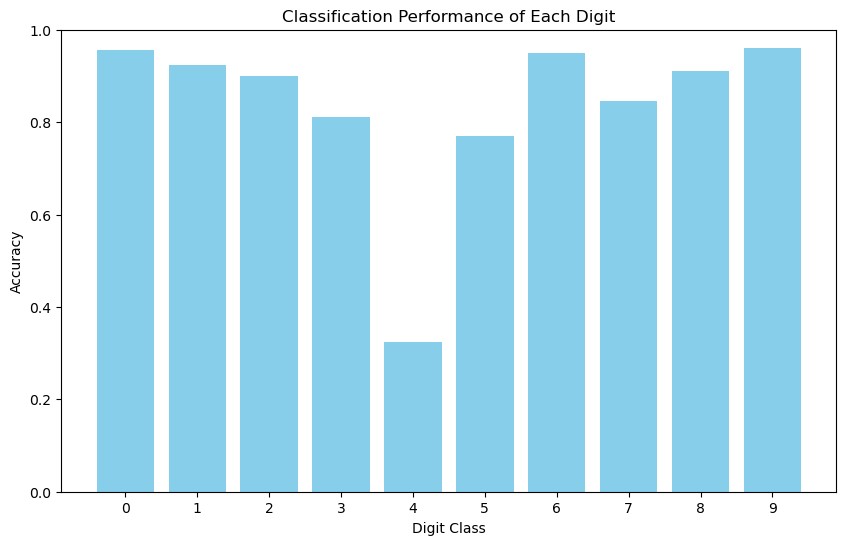

In [23]:
# 10000 (10000 * 6% = 600) images are used for training
# Load the test data
test_loader = load_mnist_test_data()

# Evaluate the model
class_accuracy = evaluate_model(trained_inference_model, test_loader)

# Plot the classification performance
plot_classification_performance(class_accuracy)

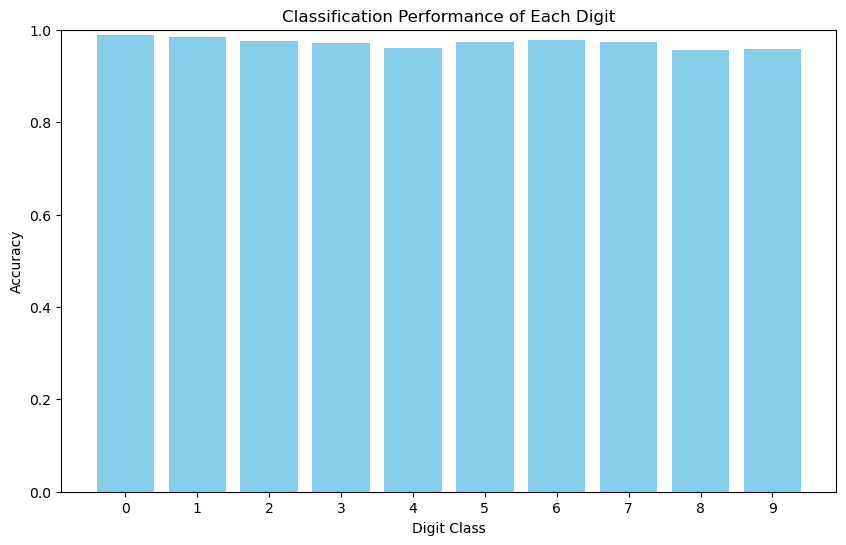

In [19]:
# 30000 (30000 * 6% = 1800) images are used for training
# Load the test data
test_loader = load_mnist_test_data()

# Evaluate the model
class_accuracy = evaluate_model(trained_inference_model, test_loader)

# Plot the classification performance
plot_classification_performance(class_accuracy)

In [41]:

# Define the standard InferenceModel with batch size 1
class StandardInferenceModel(nn.Module):
    def __init__(self):
        super(StandardInferenceModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(torch.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

def train_standard_model(num_epochs=5):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)  # Batch size of 1

    model = StandardInferenceModel()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Same learning rate as Actor-Critic model
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        for i, (data, target) in enumerate(train_loader):
            if i > 312:
                break
            data, target = data.float(), target.long()
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

    return model

# Train the standard model with the same batch size and hyperparameters
standard_inference_model = train_standard_model(num_epochs=1)

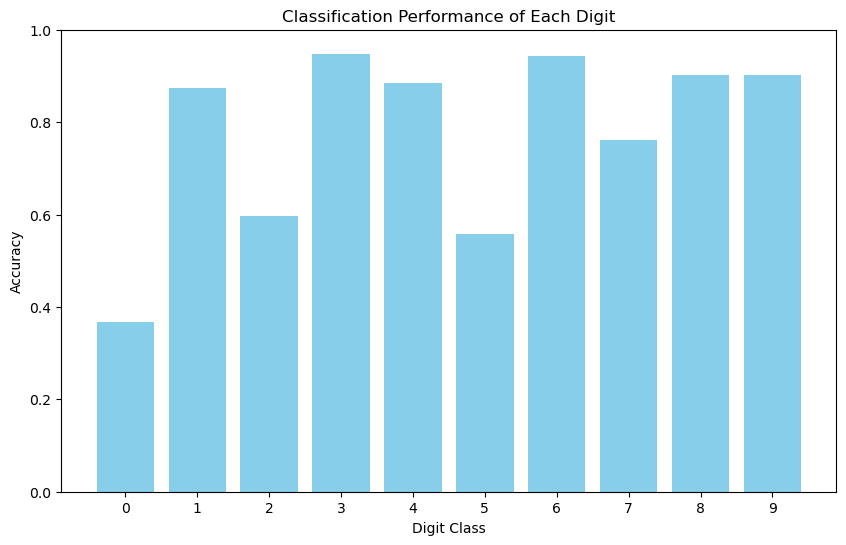

In [42]:
# 312
# Load the test data
test_loader = load_mnist_test_data()

# Evaluate the model
class_accuracy = evaluate_model(standard_inference_model, test_loader)

# Plot the classification performance
plot_classification_performance(class_accuracy)

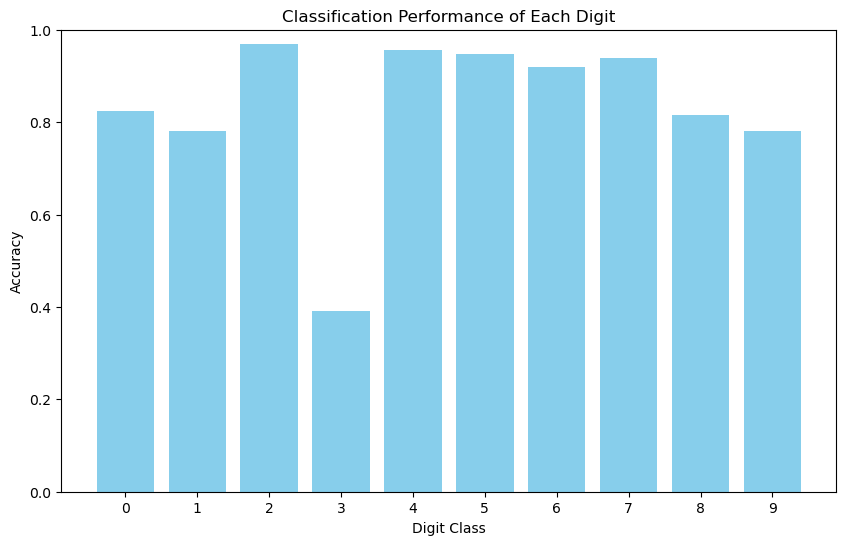

In [40]:
# 625
# Load the test data
test_loader = load_mnist_test_data()

# Evaluate the model
class_accuracy = evaluate_model(standard_inference_model, test_loader)

# Plot the classification performance
plot_classification_performance(class_accuracy)

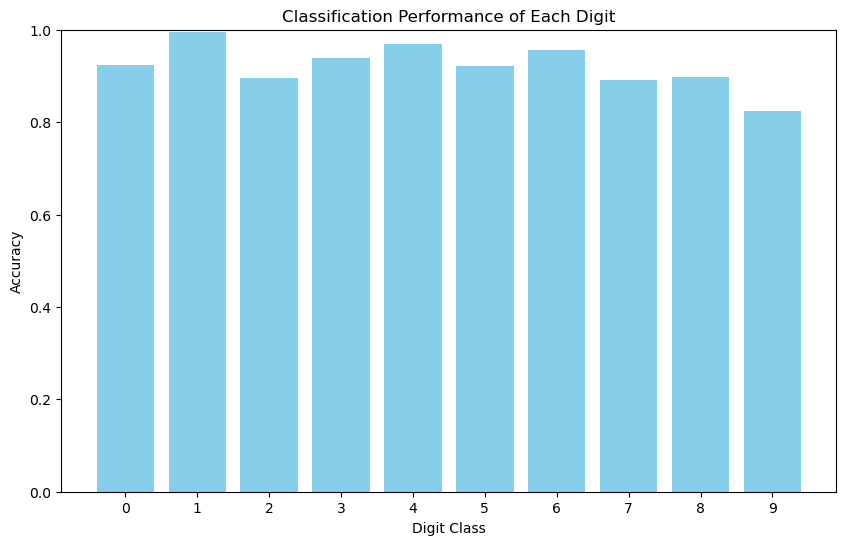

In [38]:
# 1250
# Load the test data
test_loader = load_mnist_test_data()

# Evaluate the model
class_accuracy = evaluate_model(standard_inference_model, test_loader)

# Plot the classification performance
plot_classification_performance(class_accuracy)

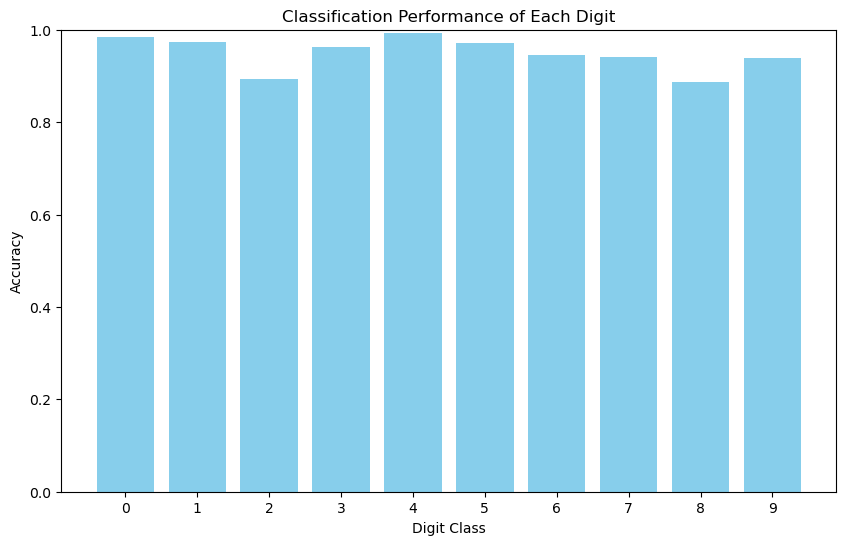

In [36]:
# 2500
# Load the test data
test_loader = load_mnist_test_data()

# Evaluate the model
class_accuracy = evaluate_model(standard_inference_model, test_loader)

# Plot the classification performance
plot_classification_performance(class_accuracy)

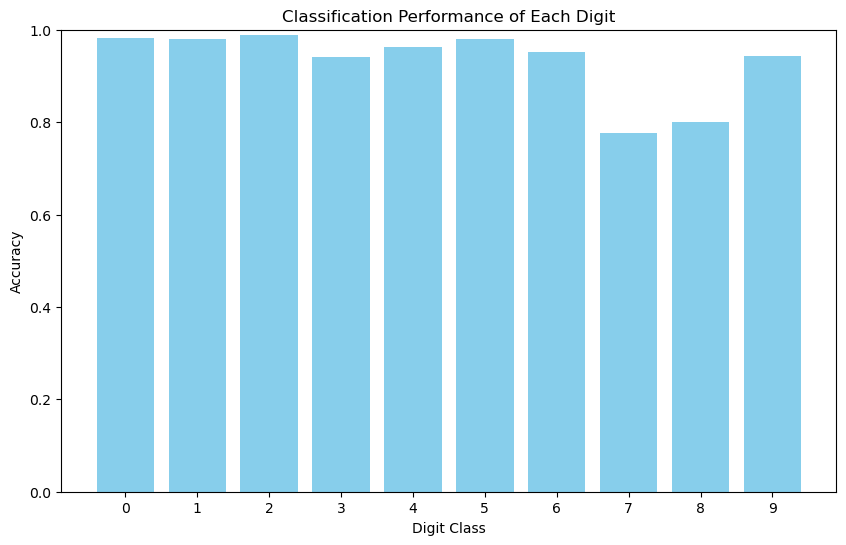

In [34]:
# 5000
# Load the test data
test_loader = load_mnist_test_data()

# Evaluate the model
class_accuracy = evaluate_model(standard_inference_model, test_loader)

# Plot the classification performance
plot_classification_performance(class_accuracy)